In [0]:
import numpy as np
from PIL import Image
import scipy.ndimage as ndimage
import matplotlib.pyplot as plt
import matplotlib.image as mimg

In [0]:
# function for convolution operation
def conv(img, kernel):
    """
        function performs convolution operation
        
        img:  input image
        kernel: filter 
    """
    
    # zeros array to store result of convolution
    result = np.zeros_like(img)
    
    # making sure the kernel is square
    # and assigning kernel length to k
    if not kernel.shape[0] is kernel.shape[0]:
        print("invalid kernel")
        return
    else:
        # k is kernel length
        k = kernel.shape[0]
        
    # looping over image to perform convolution
    # rows
    for i in range(len(img)):
        # columns
        for j in range(len(img[i])):
            # extracting a sample from image and pad it with zeros to make size similar to the kernel size
            sample = img[i:i+k, j:j+k]
            if not sample.shape is kernel.shape:
                sample = np.pad(sample, [(k-sample.shape[0],0),(0,k-sample.shape[1])], "constant")
            
            # performing convolution
            result[i,j] = np.sum(np.multiply(sample, kernel))
            
    return result

In [0]:
# This block belongs to github.com/FienSoP/
def non_max_suppression(img, D):
    # function taken from https://gist.github.com/FienSoP/03ed9b0eab196dde7b66f452725a42ac
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180

    
    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 255
                r = 255
                
               #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0

            except IndexError as e:
                pass
    
    return Z

def rgb2gray(rgb):
    # borrowed from github.com/FienSoP/ because matplotlib has issues with displaying images
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

In [0]:
def threshold(img, low, high):
    """ 
        img: input image
        low: threshold lowerbound (pixel intensity)
        high: threshold upperbound (pixel intensity)
    """
    # getting pixels with intensity higher than upperbound
    high_th_regions = np.where(img>=high)
    # getting pixels with intensity between upperbound and lowerbound
    low_th_regions = np.where((img<high) & (img>=low))
    # getting pixels with intensity lower than lowerbound
    non_relevant = np.where(img<low)
    
    # high threshold pixels are 255
    img[high_th_regions] = 255.
    # non relevant regions are discarded
    img[non_relevant] = 0.
    
    return img

<b>Let's Begin...

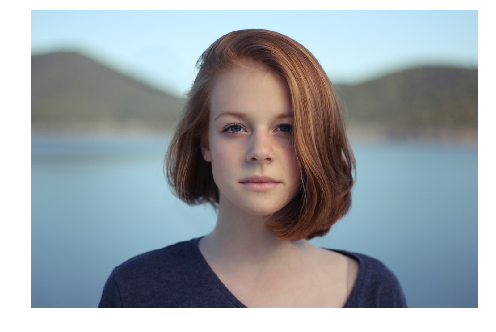

In [62]:
# loading image
img = mimg.imread("sample1.jpg")
plt.axis("off")
plt.imshow(img)
img = rgb2gray(img)

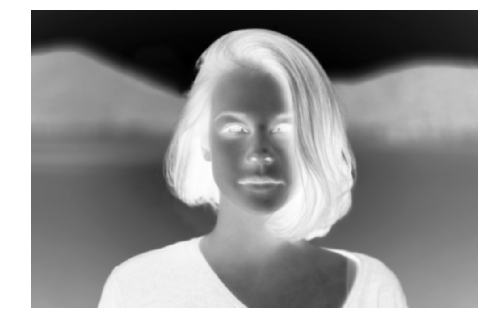

In [63]:
## STEP 1
# applying gaussian smoothing to image to remove jagged edges and noise
filtered_img = ndimage.gaussian_filter(img, sigma=1.5)
plt.axis("off")
plt.imshow(filtered_img)

### That's matplotlib screwing up with the image

In [64]:
## STEP 2
# calculating gradient using sobel operator

# initializing sobel operator 
sobel_x = np.array([[-1., 0., 1.],
                   [-2., 0., 2.],
                   [-1., 0., 1.]])

sobel_y = np.flip(np.transpose(sobel_x), axis=0)

print("sobel operator for x-axis")
print(sobel_x)
print("\nsobel operator for y-axis")
print(sobel_y)


# calculating gradient
grad_x = conv(img, sobel_x)
grad_y = conv(img, sobel_y)

sobel operator for x-axis
[[-1.  0.  1.]
 [-2.  0.  2.]
 [-1.  0.  1.]]

sobel operator for y-axis
[[ 1.  2.  1.]
 [ 0.  0.  0.]
 [-1. -2. -1.]]


gradient with sobel operator on x-axis



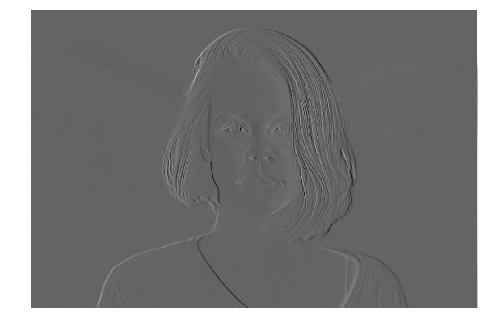

In [65]:
print("gradient with sobel operator on x-axis\n")
plt.axis("off")
plt.imshow(grad_x)

gradient with sobel operator on x-axis



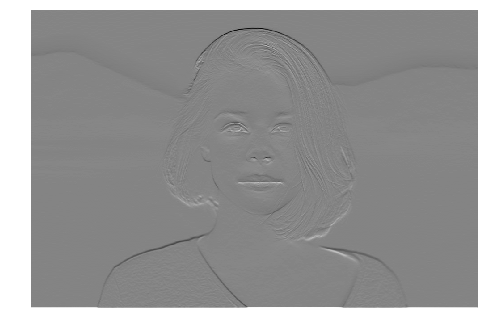

In [66]:
print("gradient with sobel operator on x-axis\n")
plt.axis("off")
plt.imshow(grad_y)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


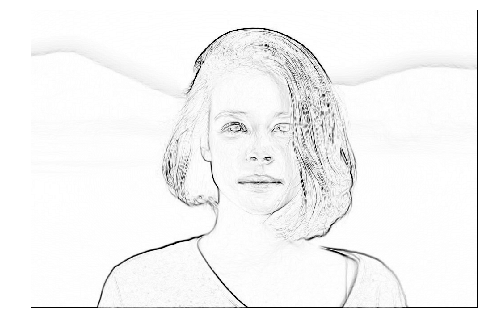

In [67]:
# calculating magnitude of gradients
magnitude = np.array(np.sqrt(grad_x**2 + grad_y**2), dtype=np.float)

# calculating angle of gradients
theta = np.arctan((grad_y/grad_x))

# clipping magnitude to range 0 to 255
magnitude = np.clip(magnitude, a_min=0., a_max=255.).astype(np.float)

plt.axis("off")
plt.imshow(magnitude)

<b>The magnitude looks good enough but let's see what else can be done...

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less
  


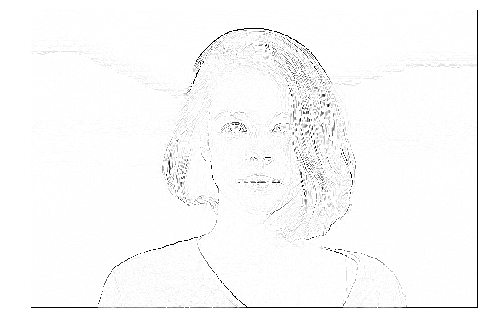

In [75]:
## STEP 3
# non max suppression
nm_img = non_max_suppression(magnitude, theta).astype(np.float32)
plt.axis("off")
plt.imshow(nm_img)

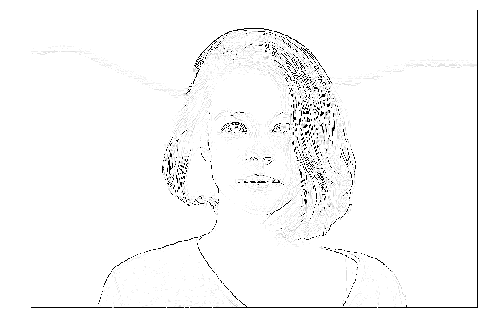

In [76]:
new_img = threshold(nm_img, low=25, high=100)

plt.axis("off")
plt.imshow(new_img)

In [0]:
## STEP 4
# hysterisis tracking, if there's a strong pixel in the neighbourhood then the current pixel will be made string
# kinda like extending the edge
def hyst_track(x, high):
    # I can't explain how I did this...
    for i in range(len(x)-1):
        for j in range(len(x[i])-1):
            if (i==0 and j==0) and (len(np.where(x[i:i+2, j:j+2] >= high)[0]) != 0):
                x[i,j] = 255
            elif (i!=0 and j==0) and (len(np.where((x[i:i+2, j:j+2] >= high) & (x[i-1:i+1, j:j+2] >= high))[0]) != 0):
                x[i,j] = 255
            elif (i==0 and j!=0) and (len(np.where((x[i:i+2, j:j+2] >= high) & (x[i:i+2, j-1:j+1] >= high))[0]) != 0):
                x[i,j] = 255
            elif (i!=0 and j!=0) and (len(np.where((x[i-1:i+1, j-1:j+1] >= high) & (x[i:i+2, j:j+2] >= high))[0]) != 0):
                x[i,j] = 255
    return x

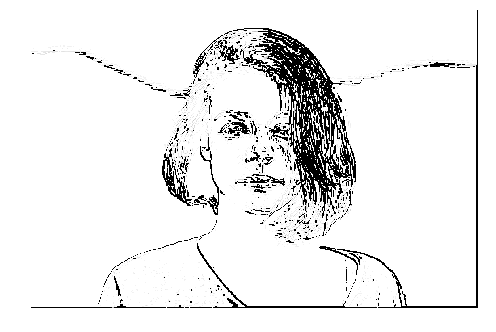

In [105]:
final_img = hyst_track(new_img, 35)
plt.axis("off")
plt.imshow(final_img)

<b>And....There it is Canny Edge Detector!